### Load and analyze CPU performance measurements from `cpu_raw.csv`

In [1]:
# Run majority of imports 
%run init.ipynb

# Reload modules to accept changes
%reload_ext autoreload
%autoreload 2

In [2]:
db = {}

source_dir = "./"
for f in os.listdir(source_dir):
    if ".csv" in f:
        file_path = source_dir + f
        db[os.path.splitext(f)[0]] = pd.read_csv(file_path) 
        print "Loaded:", file_path

Loaded: ./cpu_raw.csv


In [3]:
print "# of loaded measurements:", len(db["cpu_raw"])

# of loaded measurements: 1444517


In [4]:
df = db["cpu_raw"]
metric = "exec_time"
     
cpu_summary = []
for idx, grp in df.groupby(["site", "hw_type", "testname", "total_threads", "dvfs", "socket_num"]):
    if len(grp) > 100:

        cpu_summary.append(("-".join([str(x) for x in idx]),  
                            grp["exec_time"].std()/grp["exec_time"].mean() * 100.0,
                            len(grp),
                            grp["exec_time"].median(),
                            grp["exec_time"].quantile(0.95),
                            grp["exec_time"].quantile(0.05),
                            grp["mops_total"].std()/grp["mops_total"].mean() * 100.0,
                            grp["mops_per_thread"].std()/grp["mops_per_thread"].mean() * 100.0)
                          + idx)

cpu_summary = pd.DataFrame(cpu_summary, columns=["Config", "CoV", "Length", 
                                                 "runtime_median", "runtime_95p", "runtime_5p",
                                                 "CoV_mops_total", "CoV_mops_per_thread",
                                                 "site", "hw_type", "testname", "total_threads", "dvfs", 
                                                "socket_num"]).sort_values("CoV", ascending=False).reindex()

db["cpu_summary"] = cpu_summary

display(db["cpu_summary"].head())

Config         CoV  Length  runtime_median  \
161  clemson-c6320-MG-28-yes-1  150.631137    1462           9.186   
158   clemson-c6320-MG-28-no-0  146.912754    1462           9.275   
160  clemson-c6320-MG-28-yes-0  145.694835    1462           9.184   
159   clemson-c6320-MG-28-no-1  143.807129    1462           9.281   
118   clemson-c6320-CG-28-no-0  136.564952    1462           9.639   

     runtime_95p  runtime_5p  CoV_mops_total  CoV_mops_per_thread     site  \
161    105.93460       9.142       27.781581            27.781582  clemson   
158    107.10520       9.225       27.789093            27.789093  clemson   
160    105.04695       9.146       27.587247            27.587246  clemson   
159    104.17370       9.223       27.476277            27.476276  clemson   
118     66.51540       9.575       27.184780            27.184786  clemson   

    hw_type testname  total_threads dvfs  socket_num  
161   c6320       MG             28  yes           1  
158   c6320       MG             28   no           0  
160   c6320       MG             28  yes           0  
159   c6320       MG             28   no           1  
118   c6320       CG             28   no           0

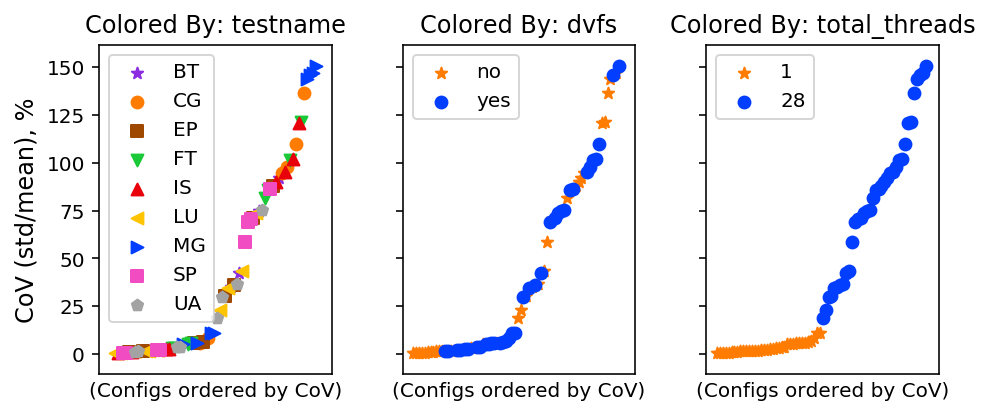

In [5]:
def get_cmap(df, column, palette="bright", custom=None):
    """ Assign unique colors to unique values in the specified column in the dataframe.
    If custom dict is provided, add it to the resulting color map.
    """
    color_labels = df[column].unique().tolist()
    rgb_values = sns.color_palette(palette, len(color_labels))
    color_map = dict(zip(color_labels, rgb_values))
    if custom:
        color_map.update(custom)
    return color_map

df = db["cpu_summary"]

ss = df[df["hw_type"]=="c6320"].copy()
ss["_order"] = np.arange(len(ss)) * (-1)

fig, axarr = plt.subplots(1, 3, figsize=(7,3),sharey=True)
markers_list = ["*", "o", ",", "v", "^", "<", ">", "s", "p", "."]

for f, ax in zip(["testname", "dvfs", "total_threads"], axarr):

    cmap = get_cmap(ss, f, palette="bright", custom=None)
    
    for idx, (f_val, grp) in enumerate(ss.groupby(f)):
        ax.scatter(grp["_order"], grp["CoV"], marker=markers_list[idx],
                   label=f_val, s=35,
                   color=cmap[f_val])
    
    ax.set_xticks([])
    ax.set_title("Colored By: %s" % f)
    ax.legend()
    ax.set_ylabel("")
    ax.set_xlabel("(Configs ordered by CoV)")
    
axarr[0].set_ylabel("CoV (std/mean), %", fontsize=12)

plt.tight_layout()
plt.savefig('cov-cpu-c6320.png', dpi=300)

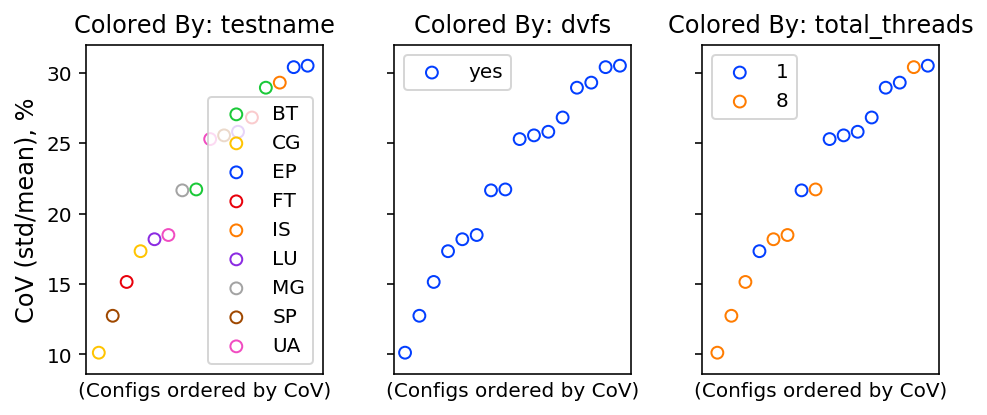

In [6]:
ss = df[df["hw_type"]=="m400"].copy()
ss["_order"] = np.arange(len(ss)) * (-1)

fig, axarr = plt.subplots(1, 3, figsize=(7,3),sharey=True)

for f, ax in zip(["testname", "dvfs", "total_threads"], axarr):

    cmap = get_cmap(ss, f, palette="bright", custom=None)
    
    for f_val, grp in ss.groupby(f):
        ax.scatter(x=grp["_order"], y=grp["CoV"], label=f_val, s=35,
                   edgecolor=cmap[f_val], facecolor="", )
    
    ax.set_xticks([])
    ax.set_title("Colored By: %s" % f)
    ax.legend()
    ax.set_ylabel("")
    ax.set_xlabel("(Configs ordered by CoV)")
    
axarr[0].set_ylabel("CoV (std/mean), %", fontsize=12)

plt.tight_layout()
plt.savefig('cov-cpu-m400.png', dpi=300)

In [7]:
skipped_low = 0
skipped_onesoc = 0
total = 0
low_thresh = 200

analysis_configs = []

df = db["cpu_raw"]

for idx, grp in df.groupby(["site", "hw_type", "testname", "total_threads", "dvfs"]):

    total += 1
    if len(grp) < low_thresh:
        #print "Skipping configuration (<%d points):" % low_thresh, idx 
        skipped_low += 1
        continue
    if grp.socket_num.nunique() == 1:
        #print "Skipping configuration (only one socket):", idx 
        skipped_onesoc += 1
        continue
        
    analysis_configs.append((idx, len(grp)))
   
analysis_configs = pd.DataFrame(analysis_configs, 
                                columns=["config", "length"]).sort_values(["length"], 
                                                                          ascending=False).reset_index(drop=True)

print "# of CPU configs:", total
print "# of configs skipped because of low # of measurements:", skipped_low
print "# of configs with single socket:", skipped_onesoc

display(analysis_configs.head())

# of CPU configs: 509
# of configs skipped because of low # of measurements: 99
# of configs with single socket: 122


config  length
0  (wisc, c220g5, UA, 20, yes)    7172
1   (wisc, c220g5, IS, 1, yes)    7172
2  (wisc, c220g5, FT, 20, yes)    7172
3   (wisc, c220g5, FT, 20, no)    7172
4   (wisc, c220g5, FT, 1, yes)    7172

In [8]:
def trim(s, thresh=0.02):
    return s[(s <= s.quantile(1-thresh)) & (s >= s.quantile(thresh))]

all_configs_stats = []

df_all = db["cpu_raw"]

for config_id in range(len(analysis_configs)):
    res = []
    
    config = analysis_configs.loc[config_id].config 
    res.append(config)

    df = df_all[(df_all.site == config[0]) & \
             (df_all.hw_type == config[1]) & \
             (df_all.testname == config[2]) & \
             (df_all.total_threads == config[3]) & \
             (df_all.dvfs == config[4]) & \
             (df_all.run_success)]

    df_by_socket_stats = []
    for socket_num, grp in df.groupby(["socket_num"]):
        vals_trimmed = trim(grp[metric])
        df_by_socket_stats.append((socket_num, len(grp), 
                                   grp[metric].median(), grp[metric].std(), grp[metric].std()/grp[metric].mean()*100, 
                                   grp[metric].quantile(0.9),
                                   grp[metric].quantile(0.1),
                                   vals_trimmed.median(),
                                   vals_trimmed.std(),
                                   vals_trimmed.std()/vals_trimmed.mean()*100,
                                   vals_trimmed.quantile(0.9),
                                   vals_trimmed.quantile(0.1)))
        
    df_by_socket_stats = pd.DataFrame(df_by_socket_stats, columns=["socket", "length", 
                                                                   "median", "std", "cov",
                                                                   "90p", "10p",
                                                                   "median_trimmed", "std_trimmed", "cov_trimmed",
                                                                   "90p_trimmed", "10p_trimmed"])

    res.extend([df_by_socket_stats.length.min(), df_by_socket_stats.length.max()])

    df_s0 = df[df.socket_num == 0][metric]
    df_s1 = df[df.socket_num == 1][metric]

    df_by_socket_r, p = stats.pearsonr(df_s0, df_s1)
    res.append(df_by_socket_r)
    
    mw_stat, mw_p = mannwhitneyu(df_s0, df_s1)
    res.append(mw_stat)
    res.append(mw_p)
    
    
    cov_s0 = df_s0.values.std() / df_s0.values.mean() * 100
    cov_s1 = df_s1.values.std() / df_s1.values.mean() * 100
    res.append(cov_s0)
    res.append(cov_s1)

    rel_diff_columns = ["median", "std", "cov", "90p", "10p", 
                        "median_trimmed", "std_trimmed", "90p_trimmed", "10p_trimmed", "cov_trimmed"]
    for c in rel_diff_columns:

        rel_diff = abs(df_by_socket_stats.iloc[0][c] - 
                       df_by_socket_stats.iloc[1][c]) /  \
                           min(df_by_socket_stats.iloc[0][c],
                           df_by_socket_stats.iloc[1][c]) * 100.0
        
        res.append(rel_diff)
            
    all_configs_stats.append(res)
    
all_configs_stats = pd.DataFrame(all_configs_stats, columns=["config", 
                                                             "length_min", "length_max",
                                                             "corr", "mw_stat", "mw_p",
                                                             "cov_s0", "cov_s1"] + \
                                                             ["rel_diff_" + x for x in rel_diff_columns])
display(all_configs_stats.head())

config  length_min  length_max      corr    mw_stat  \
0  (wisc, c220g5, UA, 20, yes)        3567        3567  0.927191  5180002.5   
1   (wisc, c220g5, IS, 1, yes)        3567        3567  0.350911  4165471.0   
2  (wisc, c220g5, FT, 20, yes)        3567        3567  0.985629  5908400.0   
3   (wisc, c220g5, FT, 20, no)        3567        3567  0.732265  6198734.0   
4   (wisc, c220g5, FT, 1, yes)        3567        3567  0.604272  4936739.5   

            mw_p    cov_s0    cov_s1  rel_diff_median  rel_diff_std  \
0   2.246586e-42  1.176452  1.132685         0.099182      3.975056   
1  1.281483e-141  0.425737  0.431241         0.185960      1.180904   
2   9.275553e-08  8.275735  8.229243         0.041093      0.727277   
3   3.043493e-02  3.205518  3.940014         0.019814     22.872743   
4   8.513042e-61  0.537543  0.487625         0.115875     10.361278   

   rel_diff_cov  rel_diff_90p  rel_diff_10p  rel_diff_median_trimmed  \
0      3.863999      0.098741      0.074608                 0.099182   
1      1.292804      0.046211      0.093110                 0.185960   
2      0.564953      0.073614      0.041229                 0.020547   
3     22.913464      0.039424      0.019897                 0.019814   
4     10.236906      0.192530      0.077429                 0.115875   

   rel_diff_std_trimmed  rel_diff_90p_trimmed  rel_diff_10p_trimmed  \
0              4.359085              0.098790              0.074590   
1              2.979406              0.092507              0.093110   
2             31.052222              0.040908              0.041220   
3             25.168839              0.019720              0.019893   
4             30.139995              0.154024              0.038700   

   rel_diff_cov_trimmed  
0              4.262734  
1              2.843499  
2             30.959160  
3             25.117284  
4             30.001398

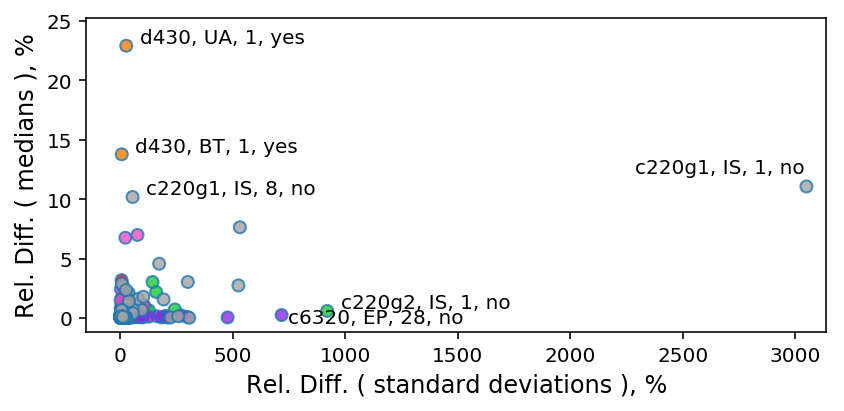

In [9]:
# Std and Median Analysis -- now look at trimmed estimates

def get_cmap(df, column, palette="bright", custom=None):
    """ Assign unique colors to unique values in the specified column in the dataframe.
    If custom dict is provided, add it to the resulting color map.
    """
    color_labels = df[column].unique().tolist()
    rgb_values = sns.color_palette(palette, len(color_labels))
    color_map = dict(zip(color_labels, rgb_values))
    if custom:
        color_map.update(custom)
    return color_map

def label_point(x, y, configs, ax):
    all_labs = []
    
    a = pd.concat({'x': x, 'y': y, 'config': configs}, axis=1)
    for i, point in a.iterrows():
        lab = ""
        if (point['y'] > 10.0) or (point['x'] > 580.0):
            lab = str(point['config'][1:]).replace("'","").replace("(","").replace(")","")
            all_labs.append(point['config'])    
            
        if point['config'][1] == "c6320":
            ax.text(point['x'] + pd.Series(x).max() * 0.01, 
                    point['y'] - pd.Series(y).max() * 0.03, 
                    lab)
        elif (point['config'][1] == "c220g1") and (point['config'][2] == 'IS') and (point['config'][3] == 1):
            ax.text(point['x'] - pd.Series(x).max() * 0.25, 
                    point['y'] + pd.Series(y).max() * 0.05, 
                    lab)
        else:
            ax.text(point['x'] + pd.Series(x).max() * 0.02, 
                    point['y'] + pd.Series(y).max() * 0.01, 
                    lab)
        
    return all_labs

all_configs_stats["hw"] = all_configs_stats["config"].apply(lambda x: x[1])
hw_cmap = get_cmap(all_configs_stats, "hw", palette="bright", custom=None)
all_configs_stats["_color"] = all_configs_stats['hw'].map(hw_cmap)

fig, ax = plt.subplots(1, 1, figsize=(6,3))
sns.regplot('rel_diff_std_trimmed', 'rel_diff_median_trimmed', data=all_configs_stats, 
                scatter_kws={'facecolors': all_configs_stats['_color']}, fit_reg=False, ax=ax);

all_labs = label_point(all_configs_stats.rel_diff_std_trimmed, 
            all_configs_stats.rel_diff_median_trimmed, 
            all_configs_stats.config, 
            plt.gca())

ax.set_ylim([ax.get_ylim()[0], ax.set_ylim()[1]* 1.05])
ax.set_xlim([ax.get_xlim()[0], ax.set_xlim()[1]* 0.98])

ax.set_xlabel("Rel. Diff. ( standard deviations ), %", fontsize=12)
ax.set_ylabel("Rel. Diff. ( medians ), %", fontsize=12)
plt.tight_layout()

plt.savefig('rel_diffs.png', dpi=300)

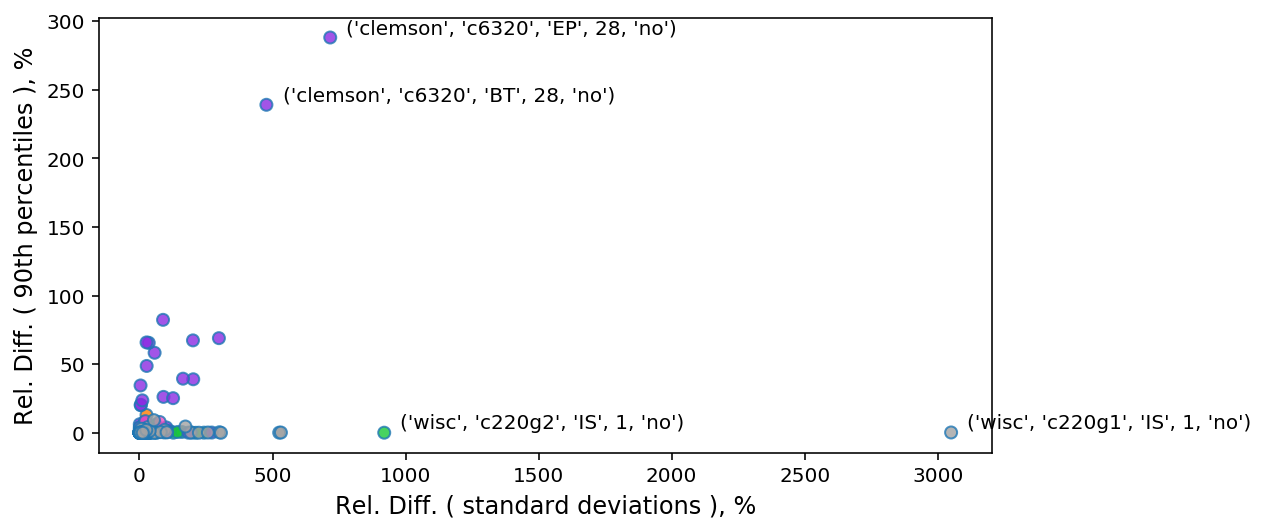

In [10]:
# Std and 90p Analysis

def label_point(x, y, configs, ax):
    all_labs = []
    a = pd.concat({'x': x, 'y': y, 'config': configs}, axis=1)
    for i, point in a.iterrows():
        lab = ""
        if (point['y'] > 100.0) or (point['x'] > 900.0):
            lab = str(point['config'])
            all_labs.append(point['config'])
            
        ax.text(point['x'] + pd.Series(x).max() * 0.02, 
                point['y'] + pd.Series(y).max() * 0.01, 
                lab)

    return all_labs

fig, ax = plt.subplots(1, 1, figsize=(8,4))
sns.regplot('rel_diff_std_trimmed', 'rel_diff_90p_trimmed', data=all_configs_stats, 
                scatter_kws={'facecolors': all_configs_stats['_color']}, fit_reg=False, ax=ax);

all_labs = label_point(all_configs_stats.rel_diff_std_trimmed, 
            all_configs_stats.rel_diff_90p_trimmed, 
            all_configs_stats.config, 
            plt.gca())

ax.set_xlabel("Rel. Diff. ( standard deviations ), %", fontsize=12)
ax.set_ylabel("Rel. Diff. ( 90th percentiles ), %", fontsize=12);

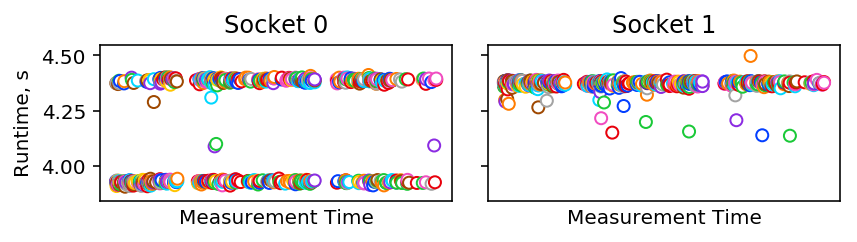

In [11]:
# Investigate specific case

df = db["cpu_raw"]

for el in all_labs:
    if str(el[1:]) == "('c220g1', 'IS', 1, 'no')":
        
        df = df[(df.site == el[0]) & \
                 (df.hw_type == el[1]) & \
                 (df.testname == el[2]) & \
                 (df.total_threads == el[3]) & \
                 (df.dvfs == el[4]) & \
                 (df.run_success)]

        df_s0 = pd.DataFrame(df[df.socket_num == 0][[metric, "nodeid", "timestamp"]])
        df_s1 = pd.DataFrame(df[df.socket_num == 1][[metric, "nodeid", "timestamp"]])

        node_cmap = get_cmap(df, "nodeid", palette="bright", custom=None)
        df_s0["_color"] = df_s0['nodeid'].map(node_cmap)
        df_s1["_color"] = df_s1['nodeid'].map(node_cmap)

        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6,1.8), sharey=True)
        ax0.scatter(x=df_s0["timestamp"], y=df_s0[metric], 
                    edgecolor=df_s0['_color'], facecolor="white")
        ax1.scatter(x=df_s1["timestamp"], y=df_s1[metric], 
                    edgecolor=df_s1['_color'], facecolor="white")

        ax0.set_title("Socket 0")
        ax1.set_title("Socket 1")
        ax0.set_xticks([])
        ax1.set_xticks([])
        ax0.set_ylabel("Runtime, s")
        ax0.set_xlabel("Measurement Time")
        ax1.set_xlabel("Measurement Time")

        plt.tight_layout()

        plt.savefig('c220g1-sockets.png', dpi=300);

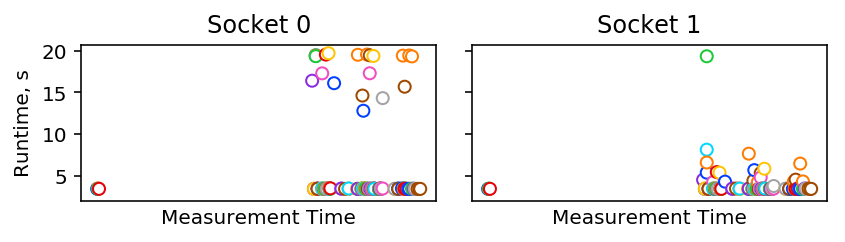

In [12]:
# Investigate another specific case

df = db["cpu_raw"]

for el in all_labs:
    if str(el[1:]) == "('c6320', 'EP', 28, 'no')":

        df = df[(df.site == el[0]) & \
                 (df.hw_type == el[1]) & \
                 (df.testname == el[2]) & \
                 (df.total_threads == el[3]) & \
                 (df.dvfs == el[4]) & \
                 (df.run_success)]

        df_s0 = pd.DataFrame(df[df.socket_num == 0][[metric, "nodeid", "timestamp"]])
        df_s1 = pd.DataFrame(df[df.socket_num == 1][[metric, "nodeid", "timestamp"]])

        node_cmap = get_cmap(df, "nodeid", palette="bright", custom=None)
        df_s0["_color"] = df_s0['nodeid'].map(node_cmap)
        df_s1["_color"] = df_s1['nodeid'].map(node_cmap)

        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6,1.8), sharey=True)
        ax0.scatter(x=df_s0["timestamp"], y=df_s0[metric], 
                    edgecolor=df_s0['_color'], facecolor="white")
        ax1.scatter(x=df_s1["timestamp"], y=df_s1[metric], 
                    edgecolor=df_s1['_color'], facecolor="white")

        ax0.set_title("Socket 0")
        ax1.set_title("Socket 1")
        ax0.set_xticks([])
        ax1.set_xticks([])
        ax0.set_ylabel("Runtime, s")
        ax0.set_xlabel("Measurement Time")
        ax1.set_xlabel("Measurement Time")

        ax0.set_yticks([5,10,15,20])

        plt.tight_layout()

        plt.savefig('c6320-sockets.png', dpi=300);